## Packages

In [1]:
#Packages to solve DE and math
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import scipy.fftpack
from statsmodels.nonparametric.kernel_regression import KernelReg

#Packages to plot and animate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter  
from collections import deque

#Packages from EXPLORE
from scipy.interpolate import interp1d, UnivariateSpline
from imripy import merger_system as ms
from imripy import inspiral
from imripy import waveform
from imripy import detector
from imripy import halo
from imripy import cosmo

#miscellaneous Packages
import time

## Orbit

In [2]:
def initial_conditions(sp, a0, e0, phi0 = 0.):
    """
    Calculate the initial conditions for a Keplerian orbit with parameters a, e
    """
    r0 = a0 * (1. - e0**2) / (1. + e0 * np.cos(phi0))
    dphi0 = np.sqrt(sp.m_total() * a0 * (1-e0**2))/ r0**2
    dr0 = a0* (1. - e0**2) / (1 + e0 * np.cos(phi0))**2 * e0 *np.sin(phi0) * dphi0
    return [r0, phi0, dr0, dphi0]


def evolve(sp, y0, t_end, t_start=0., gwEmission=True, dynamicalFriction=True, coulombLog=3., nSteps=1000):   
    """
    Evolve the system of differential equations from t_start to t_end with initial conditions y0
    """
    t_scale = t_end
    r_scale = y0[0]
    
    y0scaled = y0[:]
    y0scaled[0] /= r_scale; y0scaled[2] /= r_scale
    
    t_eval = np.linspace(t_start, t_end, nSteps)/t_scale
    
    def dy_dt(t, y, sp):
        r, phi, dr, dphi = y
        r *= r_scale; dr *= r_scale;
        
        gwEmissionTerm = 32./5. * sp.m_reduced()**2 * r**4 / (dr**2 + r**2 * dphi**2) if gwEmission else 0. 
        dynamicalFrictionTerm = 8 * np.pi * sp.m_reduced()**2 * sp.halo.density(r) * coulombLog /(dr**2 + r**2 * dphi**2)**(3./2.)  if dynamicalFriction else 0.
        
        ddr = (sp.m_reduced() * r * dphi**2
                  - sp.m_total() * sp.m_reduced() / r**2
                  - gwEmissionTerm        * 2* dr * dphi**6
                  - dynamicalFrictionTerm * dr
                  ) / sp.m_reduced()
        ddphi= (-2.*sp.m_reduced() * r * dr * dphi
                  - gwEmissionTerm        * ( 6 * dphi**5 * (dr**2 + r**2 * dphi**2) * np.log(dr**2 + r**2 * dphi**2) + 2* r**2 *dphi**7)
                  - dynamicalFrictionTerm * r**2 * dphi
               ) / (sp.m_reduced() * r**2)
        #print(y, np.array([dr/r_scale, dphi, ddr/r_scale, ddphi]) * t_scale)
        return np.array([dr/r_scale, dphi, ddr/r_scale, ddphi]) * t_scale
    
    rt_start = time.perf_counter()
    sol=solve_ivp(dy_dt, [t_start/t_scale, t_end/t_scale], y0scaled, method='RK45', args=(sp, ),
                          dense_output=True, atol=1e-9, rtol=1e-5, t_eval=t_eval)
    rt_elapsed = time.perf_counter() - rt_start
    
    sol.t *= t_scale
    sol.y[0] *= r_scale
    sol.y[2] *= r_scale
    print(sol.message)
    print("elapsed time ", rt_elapsed)
    return sol

In [3]:
def plotOrbit(sp, sol, ax_polar, label=""):
    r = sol.y[0]; phi = sol.y[1]
    trace, = ax_polar.plot(phi, r/sp.r_isco(), linestyle='--', lw=1, label=label)

In [4]:
m1= 1e3* ms.solar_mass_to_pc
m2= 1. * ms.solar_mass_to_pc
D = 1e5 

sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)

In [5]:
a0 = 100. * sp_0.r_isco()
e0 = 0.1
y0 = initial_conditions(sp_0, a0, e0)
print(y0)
F0 = np.sqrt(sp_0.m_total()/a0**3)/ 2./np.pi
nOrbits = 5000
t_end = nOrbits/ F0
sol_0 = evolve(sp_0, y0, t_end, gwEmission=False, nSteps=10*nOrbits)

[2.592e-08, 0.0, 0.0, 1742133.7896178223]
The solver successfully reached the end of the integration interval.
elapsed time  122.1080738


In [6]:
print(y0)
sol_0gw = evolve(sp_0, y0, t_end, gwEmission=True, nSteps=10*nOrbits)

[2.592e-08, 0.0, 0.0, 1742133.7896178223]
The solver successfully reached the end of the integration interval.
elapsed time  85.94073990000001


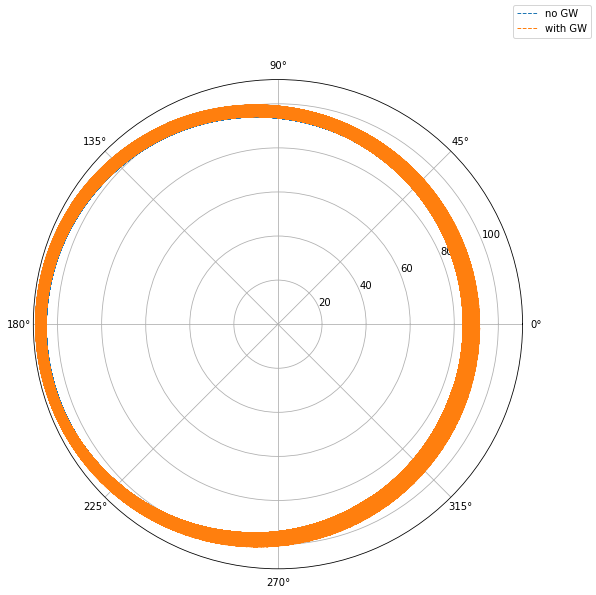

In [7]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='polar')
plotOrbit(sp_0, sol_0, ax, 'no GW')
plotOrbit(sp_0, sol_0gw, ax, 'with GW')
fig.legend();

In [8]:
def getOrbitalParameters(sp, sol, smooth_e=True):
    """
    Try to calculate a, e as Keplerian paramters from the evolution
    """
    r = sol.y[0]; phi = sol.y[1]; dr = sol.y[2]; dphi = sol.y[3]
    R = dphi**2 * r**4 / sp.m_total()
    
    e = np.where(np.abs(np.cos(phi)) > 0.5, (R/r - 1.)/np.cos(phi), -1.) # Only look at parts where cos(phi) is far from zero
    e[np.where(e < 0.)] = interp1d(sol.t[np.where(e>=0.)], e[np.where(e>=0.)], kind='cubic', 
                                       bounds_error=False, fill_value='extrapolate')(sol.t[np.where(e<0.)])
    
    if smooth_e:
        # this call can take a long time, so put it into parts to speed up
        t_start = time.perf_counter()
        N = len(e)//10000
        e_parts = np.array_split(e, N); t_parts = np.array_split(sol.t, N)
        for i in range(len(e_parts) ):
            kr = KernelReg(e_parts[i], t_parts[i], 'c')
            e_parts[i], _ = kr.fit(t_parts[i])
        e = np.concatenate(e_parts)
        t_elapsed = time.perf_counter()-t_start
        print(f"kernel regression of {len(e)} data points in {N} parts, elapsed time: {t_elapsed}")
    
    a = R/ (1. - e**2)
    sol.a = a; sol.e = e
    return sol
    
def plotOrbitalParameters(sp, sol, ax_a, ax_e, label=""):
    if not hasattr(sol, 'a'):
        sol = getOrbitalParameters(sp, sol)
    l, = ax_a.plot(sol.t, sol.a/sp.r_isco(), label=label)
    ax_e.plot(sol.t, sol.e, color=l.get_c())
    #ax_e.plot(t, sol.y[1], linestyle='--', color=l.get_c())
    #ax_e.plot(t, np.cos(sol.y[1]), linestyle='-.', color=l.get_c())
    return sol

kernel regression of 50000 data points in 5 parts, elapsed time: 57.052564200000006
kernel regression of 50000 data points in 5 parts, elapsed time: 56.74016220000004


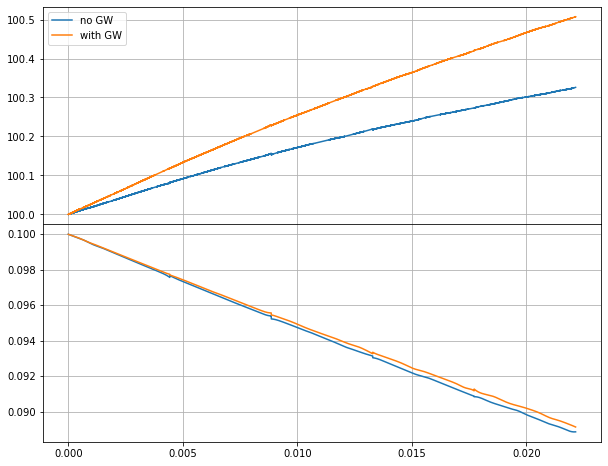

In [9]:
fig, (ax_a, ax_e) = plt.subplots(2,1, sharex='all', figsize=(10, 8))
fig.subplots_adjust(hspace=0.)
sol_0 = plotOrbitalParameters(sp_0, sol_0, ax_a, ax_e, label='no GW')
sol_0gw = plotOrbitalParameters(sp_0, sol_0gw, ax_a, ax_e, label='with GW')
ax_a.grid(); ax_e.grid()
ax_a.legend()

### Gravitational Wave Signal

In [10]:
def strain(sp, sol):
    r = sol.y[0]; phi = sol.y[1];
    t = sol.t
    #Observer parameters
    mu = sp.m_reduced()
    theta_o=np.pi/2
    phi_o=np.pi/2

    #Rotating body parameters
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    z = np.zeros(np.shape(x))
    
    Q=[ [mu*x*x, mu*x*y, mu*x*z],
           [mu*y*x, mu*y*y, mu*y*z],
           [mu*z*x, mu*z*y, mu*z*z] ]
    
    def Mdt(Q):
        return np.array([ [np.gradient(Q[0][0], t), np.gradient(Q[0][1], t), np.gradient(Q[0][2], t)], 
                            [np.gradient(Q[1][0], t),np.gradient(Q[1][1], t),np.gradient(Q[1][2], t)],
                            [np.gradient(Q[2][0], t),np.gradient(Q[2][1], t),np.gradient(Q[2][2], t)] ])
    dQdt=Mdt(Q)
    d2Qd2t=Mdt(dQdt)
    
    h_plus =  1./sp.D * ( d2Qd2t[0][0] * (np.cos(phi_o)**2 - np.sin(phi_o)**2 * np.cos(theta_o)**2) 
                         + d2Qd2t[1][1] * (np.sin(phi_o)**2 - np.cos(phi_o)**2 * np.cos(theta_o)**2) 
                         - d2Qd2t[2][2] * np.sin(theta_o)**2 
                         - d2Qd2t[0][1] * np.sin(2*phi_o) * (1. + np.cos(theta_o)**2)
                         + d2Qd2t[0][2] * np.sin(phi_o) * np.sin(2*theta_o) 
                         + d2Qd2t[1][2] * np.cos(phi_o) * np.sin(2*theta_o) )      
    h_cross = 1./sp.D * ( (d2Qd2t[0][0]-d2Qd2t[1][1]) * np.sin(2*phi_o)*np.cos(theta_o)
                         + 2. * d2Qd2t[0][1] * np.cos(2*phi_o)*np.cos(theta_o) 
                         - 2. * d2Qd2t[0][2] * np.cos(phi_o)*np.sin(theta_o) 
                         + 2. * d2Qd2t[1][2] * np.sin(theta_o)*np.sin(phi_o) )
    
    sol.h_plus = h_plus; sol.h_cross = h_cross
    return sol

def strainFFT(sp, sol, f_bin):
    N = len(sol.t)
    T = sol.t[1] - sol.t[0]
    
    h_plus_fft = scipy.fftpack.fft(sol.h_plus)
    h_cross_fft = scipy.fftpack.fft(sol.h_cross)
    xf = scipy.fftpack.fftfreq(N, T)[:N//2]
    
    h_plus_fft = h_plus_fft[np.where((xf > f_bin[0]) & (xf < f_bin[1]))]
    h_cross_fft = h_cross_fft[np.where((xf > f_bin[0]) & (xf < f_bin[1]))]
    xf = xf[np.where((xf > f_bin[0]) & (xf < f_bin[1]))]
    
    sol.f = xf; sol.h_plus_fft = h_plus_fft; sol.h_cross_fft = h_cross_fft
    return sol


In [11]:
def plot_strain(sp, sol, ax_h_plus, ax_f=None, label="", plot_h_cross=False):
    l, = ax_h_plus.plot(sol.t/ms.year_to_pc, sol.h_plus, label=label)
    if plot_h_cross:
        ax_h_cross.plot(sol.t/ms.year_to_pc, sol.h_cross, color=l.get_c(), linestyle='--')
    if ax_f is None:
        return
    ax_f.plot(sol.f/ms.hz_to_invpc, 2.*sol.f*np.abs(sol.h_plus_fft), color=l.get_c())


In [12]:
sol_0 = strain(sp_0, sol_0)
sol_0 = strainFFT(sp_0, sol_0, [1e-4*ms.hz_to_invpc, 1e-1*ms.hz_to_invpc])

orbital freq:  0.002193581034886704


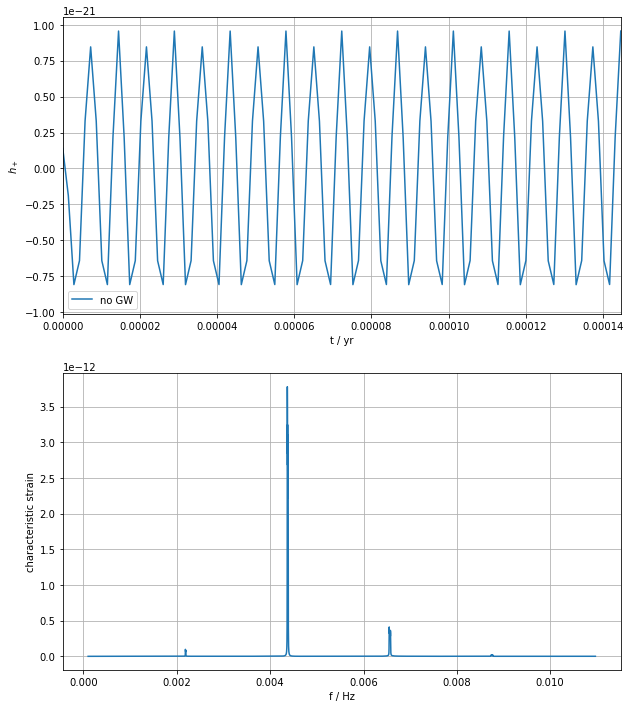

In [13]:
fig, (ax_h_plus, ax_f) = plt.subplots(2, 1, figsize=(10,12))
plot_strain(sp_0, sol_0, ax_h_plus, ax_f=ax_f, label="no GW")

ax_h_plus.set_xlabel("t / yr"); ax_h_plus.set_ylabel("$h_+$")
ax_h_plus.grid(); ax_h_plus.legend(); ax_h_plus.set_xlim(left=0., right=10./F0/ms.year_to_pc)
ax_f.set_xlabel("f / Hz"); ax_f.set_ylabel("characteristic strain"); ax_f.grid(); 
print("orbital freq: ", F0/ms.hz_to_invpc)

### DM model comparison

In [14]:
m1= 1e3* ms.solar_mass_to_pc
m2= 1. * ms.solar_mass_to_pc
D = 1e5 

sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)

rho_spike = 226. * ms.solar_mass_to_pc
alpha_spike = 7./3.
r_spike = 0.54
sp_spike = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, alpha_spike), D)

rho_s = 3.8e-22 * ms.g_cm3_to_invpc2
r_s = 23.1
sp_nfw = ms.SystemProp(m1, m2, halo.NFW(rho_s, r_s), D)

# SIDM profile is missing

In [15]:
a0 = 50. * sp_0.r_isco()
e0 = 0.
y0 = initial_conditions(sp_0, a0, e0)
print(y0)
F0 = np.sqrt(sp_0.m_total()/a0**3)/ 2./np.pi
nOrbits = 5000
t_end = nOrbits/ F0

[1.44e-08, 0.0, 0.0, 4011381.056885408]


In [16]:
sol_0 = evolve(sp_0, y0, t_end, nSteps=10*nOrbits)
sol_spike = evolve(sp_spike, y0, t_end, nSteps=10*nOrbits)
sol_nfw = evolve(sp_nfw, y0, t_end, nSteps=10*nOrbits)

The solver successfully reached the end of the integration interval.
elapsed time  65.49344540000004
The solver successfully reached the end of the integration interval.
elapsed time  67.40099779999997
The solver successfully reached the end of the integration interval.
elapsed time  66.26647420000006


kernel regression of 50000 data points in 5 parts, elapsed time: 61.624727699999994
kernel regression of 50000 data points in 5 parts, elapsed time: 60.73180239999999
kernel regression of 50000 data points in 5 parts, elapsed time: 59.87564800000007


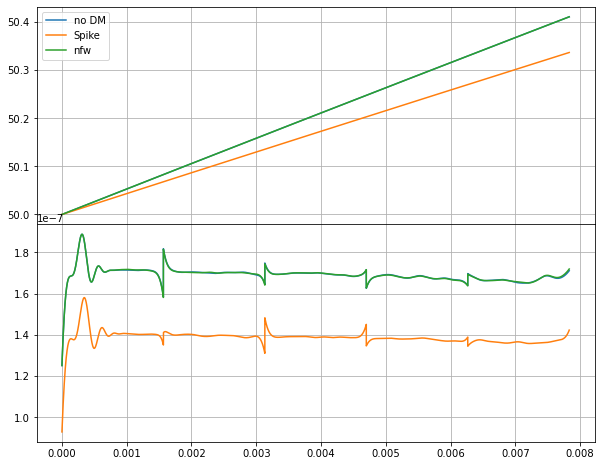

In [17]:
fig, (ax_a, ax_e) = plt.subplots(2,1, sharex='all', figsize=(10, 8))
fig.subplots_adjust(hspace=0.)
sol_0 = plotOrbitalParameters(sp_0, sol_0, ax_a, ax_e, label='no DM')
sol_spike = plotOrbitalParameters(sp_spike, sol_spike, ax_a, ax_e, label='Spike')
sol_nfw = plotOrbitalParameters(sp_nfw, sol_nfw, ax_a, ax_e, label='nfw')
ax_a.grid(); ax_e.grid()
ax_a.legend()

orbital freq:  0.006204384099402372


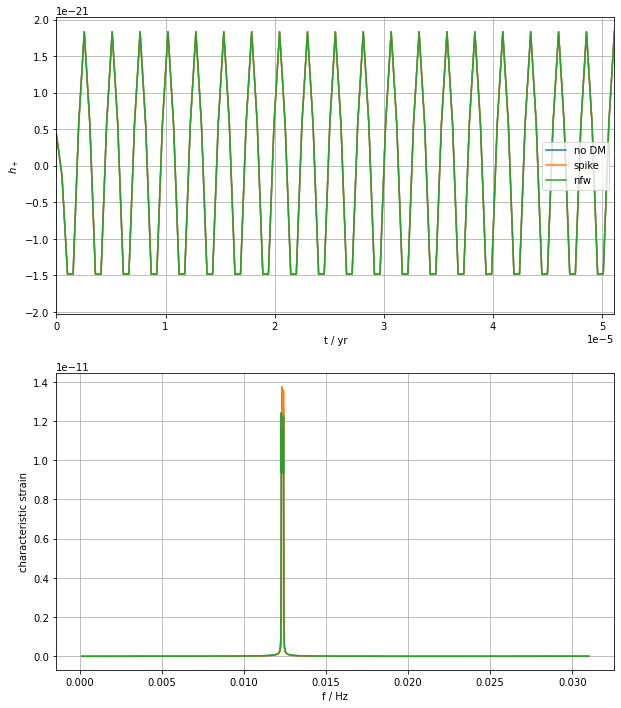

In [18]:
fig, (ax_h_plus, ax_f) = plt.subplots(2, 1, figsize=(10,12))
f_band = [1e-4*ms.hz_to_invpc, 1e-1*ms.hz_to_invpc]

sol_0 = strain(sp_0, sol_0)
sol_0 = strainFFT(sp_0, sol_0, f_band)
plot_strain(sp_0, sol_0, ax_h_plus, ax_f=ax_f, label="no DM")

sol_spike = strain(sp_spike, sol_spike)
sol_spike = strainFFT(sp_spike, sol_spike, f_band)
plot_strain(sp_spike, sol_spike, ax_h_plus, ax_f=ax_f, label="spike")

sol_nfw = strain(sp_nfw, sol_nfw)
sol_nfw = strainFFT(sp_nfw, sol_nfw, f_band)
plot_strain(sp_nfw, sol_nfw, ax_h_plus, ax_f=ax_f, label="nfw")

ax_h_plus.set_xlabel("t / yr"); ax_h_plus.set_ylabel("$h_+$")
ax_h_plus.grid(); ax_h_plus.legend(); ax_h_plus.set_xlim(left=0., right=10./F0/ms.year_to_pc)
ax_f.set_xlabel("f / Hz"); ax_f.set_ylabel("characteristic strain"); ax_f.grid(); 
print("orbital freq: ", F0/ms.hz_to_invpc)

r_1 = 0.03554993243764175 kpc, r_spike = 0.0003146915111246764 kpc, sigma_0 = 3.696902785762097 km / s


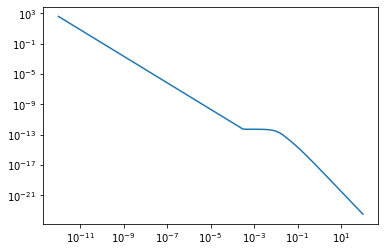

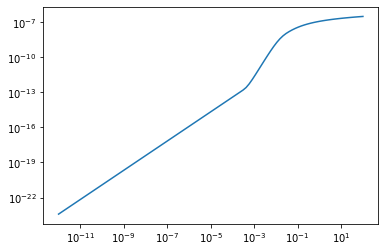

In [24]:
from astropy.units.quantity import Quantity
import matplotlib.pyplot as plt

from SIDM import SIDM
#from merger_system import solar_mass_to_pc
# from halo import NFW as NFW_niklas
import halo

class SIDM_natural_units():

    def __init__(self, rho_s_nat: float, r_s_nat: float, sigma_over_m: Quantity, BH_mass_nat: float = None, r_min_nat: float = 1e-1, r_max_nat: float = 1e5):
        rho_s = Quantity(rho_s_nat / ms.solar_mass_to_pc, 'M_sun/pc3')
        r_s = Quantity(r_s_nat, 'pc')
        sigma_over_m = sigma_over_m
        BH_mass = Quantity(BH_mass_nat / ms.solar_mass_to_pc, 'M_sun')
        r_min = Quantity(r_min_nat, 'pc')
        r_max = Quantity(r_max_nat, 'pc')
        self.profile = SIDM(rho_s, r_s, sigma_over_m, BH_mass, min(
            r_min, Quantity(1e-9, 'pc')), max(r_max, Quantity(1e2, 'pc')))
        self.r_range = self.profile.r_range
        self.r_1 = self.profile.r_1
        self.sigma_0 = self.profile.sigma_0
        self.r_spike = self.profile.r_spike

    def density(self, r):
        density = self.profile.density(Quantity(r, 'pc').to('kpc'))
        return density.to('M_sun/pc3').value * ms.solar_mass_to_pc

    def mass(self, r):
        mass = self.profile.mass(Quantity(r, 'pc').to('kpc'))
        return mass.to('M_sun').value * ms.solar_mass_to_pc


if __name__ == "__main__":
    sigma_over_m = Quantity(0.1, 'cm2/g')
    bh_mass = 1e3 * ms.solar_mass_to_pc
    dm_mass = 1e6 * ms.solar_mass_to_pc
#     rho_s = NFW_niklas.FromHaloMass(dm_mass, 20.).rho_s
#     r_s = NFW_niklas.FromHaloMass(dm_mass, 20.).r_s
    rho_s = halo.NFW.FromHaloMass(dm_mass, 20.).rho_s
    r_s = halo.NFW.FromHaloMass(dm_mass, 20.).r_s

    profile = SIDM_natural_units(rho_s, r_s, sigma_over_m, bh_mass)
    print(
        f'r_1 = {profile.r_1}, r_spike = {profile.r_spike}, sigma_0 = {profile.sigma_0}')
    plt.loglog(profile.r_range, profile.density(profile.r_range))
    plt.show()
    plt.loglog(profile.r_range, profile.mass(profile.r_range))
    plt.show()


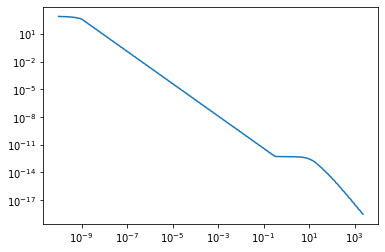

In [26]:
#r_grid = np.geomspace( r_schwarzschild, 100*r_s, 1000)
r_grid = np.geomspace( 2*m1, 100*r_s, 1000)
plt.loglog(r_grid,profile.density(r_grid))


In [27]:
#Plotting effective potential (for 2 body problem)
%matplotlib nbagg
r_eff = np.geomspace(state[0]*1e-2,state[0]*1e2, 1000)
L=state[-1]*(mu*(r[0])**2)
E=-G*(m1+m2)*mu/r[0]+L**2/(2*mu*r[0]**2)+state[2]**2*mu/2
v_eff=-G*(m1+m2)*mu/r_eff+L**2/(2*mu*r_eff**2)

E_eff=E*np.ones(len(r_eff))
plt.plot(r_eff,v_eff,label='Effective Potential')
plt.plot(r_eff,E_eff,label='Initial Energy')
plt.plot(r[0]*np.ones(len(r_eff)),np.linspace(min(v_eff),max(v_eff),len(r_eff)),label='Initial Radius')
plt.title('Effective Potential',fontsize=20,fontweight ="bold")
plt.xlabel('r/pc ')
plt.ylabel('Energy')
plt.xscale("log")
#plt.yscale("log")
plt.legend(); plt.grid();

NameError: name 'state' is not defined